# Regresión en Spark con Python

## Tratamiento de datos masivos - Rafael Caballero



### Introducción
La **regresión** es una técnica de aprendizaje automático supervisado, que busca relacionar una variable *y* con un vector de variables *X*. En particular, se busca una **función de regresión** que, dados unos valores para los parámetros de entrada *X*, sea capaz de calcular el valor *y* con el menor error posible. 

Hay varios tipos, según la forma de la función:

* Regresión lineal: se asume que la variable y, de tipo continuo o con una gran cantidad de valores discretos se puede calcular a partir de X mediante la ecuación de una línea recta.

* Regresión logística: se asume que la variable y solo puede tomar dos valores (variable dicotómica o *dummy*). En este sentido se puede considerar un *método de clasificación*. En regresión logística se supone que a partir de determinados valores de X la y cambia de 0 a 1.

* Regresión de Poisson: la variable y sigue una distribución de Poisson, en particular se asume que el logaritmo de y sigue una regresión lineal con respecto a X. La distribución de Poisson es útil para modelar el número de veces que ocurre fenómenos que suceden de forma independiente en un cierto intervalo de tiempo, como por ejemplo el número de llamadas en call center por hora.

* Regresión lineal generalizada: es un modelo que intenta reunir las 3 anteriores (y otras), y está incluido en Spark. Incluye una "familia" de funciones que puede ser "gaussian", "binomial", "poisson", "gamma" y "tweedie". A su vez cada miembro de la familia tiene funciones link que especifican la relación entre la variable dependiente y el resto. Más detalles [aquí](http://spark.apache.org/docs/2.2.2/api/java/org/apache/spark/ml/regression/GeneralizedLinearRegression.html)

* Otros métodos: basados en árboles de decisión, en métodos de incremento de gradiente...

### Aprendizaje en Spark. Esquema general.

Como veremos el método es el mismo en todos los métodos. Una vez preparados los datos:

1.- Preparar el regresor/clasificador.

2.- Aplicarlo con *fit* al conjunto de entrenamiento, lo que genera un modelo.

3.- Aplicar el modelo al conjunto que queramos con *transform*.

### Ajuste de hiperparámetros

En el paso 1 le daremos valor a distintos hiperparámetros que ajustan el método. Cada método tiene sus propios hiperparámetros. Sin embargo podemos commentar algunos de los más comunes:

* maxIter : casi todos los métodos proceden de forma iterativa, generando mejores resultados para el conjunto de entrenamiento, aunque un número demasiado elevado puede provocar que se tarde demasiado y que además haya sobreajuste

* regParam: Destinado a evitar el sobreajuste. Básicamente da cierto margen al método para que admite mayores errores sin tener que adaptarse demasiado a los valores de entrenamiento. Valores como 0.1, 0.2 o 0.3 son habituales.

* elasticNetParam: propio de Spark; combina dos formas de regularización (L1 y L2) y este parámetro indica qué peso se le da a cada una. [Aquí](https://spark.apache.org/docs/2.3.2/mllib-linear-methods.html) se puede leer más información sobre este tema.

Para obtener los mejores parámetros se utiliza la técnica de *búsqueda en rejilla* sobre la que podemos leer más [aquí](https://spark.apache.org/docs/2.2.0/ml-tuning.html) para el caso de Spark, y [aquí] una discusión general sobre optimización de hiperparámetros.


### Medida del error

Para medir el error, el paso 3. se aplicará al conjunto de test, y se usará alguna medida de error. Las más usuales en el caso de regresión:


**Coeficiente de correlación r^2**: Solo tiene sentido para regresión lineal. Si la regresión es lineal el valor r^2 (coeficiente de correlación) es un buen indicador, cuanto más cercano a uno mejor será la aproximación.

**Error absoluto medio  (MAE)**: Da una idea de los residuos esperables. Sigue la fórmula:

![MAE.png](https://i.imgur.com/BmBC8VW.jpg)

Un valor de 0 significa que no hay error. No da importancia a los outliers.

**Error cuadrático medio(MSE)**

Sigue la fórmula: 
![MSE.png](https://i.imgur.com/vB3UAiH.jpg)

da importancia a los outliers

**Raíz del error cuadrático medio (RMSE)**: igual que el anterior pero con la ventaja de que tiene las mismas unidades que los valores originales.

[Referencia](https://www.dataquest.io/blog/understanding-regression-error-metrics/)


### setup

In [3]:
%matplotlib inline
import os
# cambiamos las variables del sistema
spark = 'C:\\hlocal\\tdm\\spark\\hadoop\\spark-2.3.2-bin-hadoop2.7'
# en el path se añade
path = os.environ.get('PATH') 
path = path+ ';'+spark+'\\bin;'
os.environ['PATH'] = path
os.environ['SPARK_HOME']= spark 
os.environ['HADOOP_HOME']= spark 
os.environ['PYSPARK_DRIVER_PYTHON']= 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']='notebook'

# si da problema con collect quizás haya que poner java_home
os.environ['JAVA_HOME']= 'C:\\Program Files\\Java\\jdk1.8.0_151'
#labs = 'C:\\JDK\\jdk8-64bits'
#os.environ['JAVA_HOME']= labs
os.environ['PATH'] = os.environ.get('JAVA_HOME')+'\\bin;'+path


import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
print("Preparado!!")


Preparado!!


In [77]:
import numpy as np

# #############################################################################
# Datos de prueba
puntos = 400
X = np.sort(5 * np.random.rand(puntos, 1), axis=0).ravel()
pendiente = 10
intercep = 2
y = X*pendiente+intercep

# para la gráfica
etiq = 'X*'+str(pendiente)+'+'+str(intercep)


In [78]:
##  Otros datos de prueba; función seno
y = 2*np.sin(X*X)
etiq = "2 sen (X^2)"

In [79]:
## y aun otros
mitad = len(X)//2
print(mitad)
y = [ int(x>mitad) for x in range(len(X))]
etiq = "x>"+str(mitad)

200


Mostramos la gráfica de la función elegida

400 400


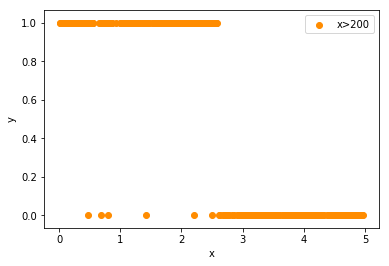

In [80]:
import matplotlib.pyplot as plt
# ruido en uno de cada s valores        
s = 10
y[::s] += 2 * (0.5 - np.random.rand(puntos//s))

# en el caso de  regresión logística tiene que ser etiqueta 1 o 0
if etiq.startswith("x>"):
    y = [ int(v<=0) for v in y]

print(len(X),len(y))

# grabamos el resultado
path = 'c:/hlocal/tdm/regresion.csv'
with open(path,'w') as file:
    file.write("label,x\n")
    for i in range(len(X)):
        file.write(str(y[i])+','+str(X[i])+'\n')



plt.scatter(X, y, color='darkorange', label=etiq)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


Cargamos los datos desde Spark

root
 |-- label: integer (nullable = true)
 |-- x: double (nullable = true)



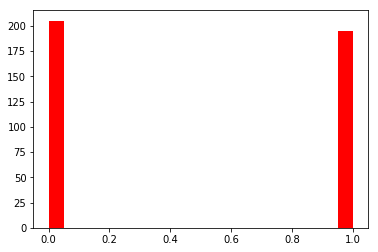

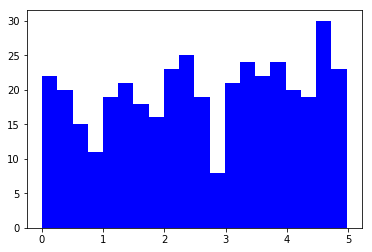

,0,1,2,3,4
summary,count,mean,stddev,min,max
label,400,0.4875,0.5004697041900039,0,1
x,400,2.6299348495436035,1.4639455162840609,0.010864313535796644,4.970282168609955


In [81]:
from pyspark.sql import SparkSession


# Load  data
datos = spark.read.format("com.databricks.spark.csv")\
            .options(header='true', inferschema='true') \
            .load(path)
datos.printSchema()

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
hist(ax, datos.select(['label']), bins = 20, color=['red'])
plt.show()
fig,ax = plt.subplots()
hist(ax, datos.select(['x']), bins = 20, color=['blue'])
plt.show()
datos.describe().toPandas().transpose()


In [82]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# nombres de columna que no sean label (label es el nombre en Spark para la y)
vectorcols = [x for x in datos.columns if x not in ['label']]

# genera un vector a partir de los valores X
assembler = VectorAssembler(
    inputCols=vectorcols,
    outputCol='features')

datosprep =  assembler.transform(datos)
datosprep = datosprep.select(['label','features'])

datosprep.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[0.01086431353579...|
|    1|[0.01754097783147...|
|    1|[0.05697526793439...|
|    1|[0.06070887670675...|
|    1|[0.07366327034390...|
+-----+--------------------+
only showing top 5 rows



In [83]:
# entrenamiento y test
splits = datosprep.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]
display(train_df.select('label','features'))

DataFrame[label: int, features: vector]

### Regresión lineal

In [84]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(train_df)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)


Coefficients: [-0.10674739900440351]
Intercept: 0.7784697832149068
+--------------------+
|           residuals|
+--------------------+
| -0.7275324507362706|
| -0.7051151378541871|
|  -0.692404040065113|
| -0.6277082330431498|
| -0.4974843694535505|
|-0.49315929282810894|
|  -0.490361273829594|
|-0.48947135279628284|
|-0.48745578312810645|
| -0.4870873927221975|
| -0.4827766455117393|
|-0.47599136868680686|
|-0.47321162353586055|
|-0.46463525063541605|
|-0.46294354852736286|
| -0.4605797697211265|
| -0.4565082420860824|
|  -0.454757598447906|
| -0.4533677296187967|
| -0.4533597910059775|
+--------------------+
only showing top 20 rows

RMSE: 0.379175
r2: 0.424905


In [85]:
#### Para ver lo bueno que es el ajuste debemos usar los valores de test
lr_predictions = lrModel.transform(test_df)
lr_predictions.select("prediction","label","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator

metrics=["r2","mae","mse","rmse"]
evaluators = [(m,RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName=m)) for m in metrics]

errors = [ (name, eval.evaluate(lr_predictions)) for name,eval in evaluators]
print(errors)


+-------------------+-----+--------------------+
|         prediction|label|            features|
+-------------------+-----+--------------------+
| 0.5425600008236505|    0| [2.209981550759139]|
| 0.5119541236360909|    0|[2.4966946460945776]|
| 0.4996039081267676|    0|[2.6123903503881674]|
|0.48896363890842437|    0| [2.712067432149235]|
|  0.483719753849574|    0|[2.7611916741238245]|
+-------------------+-----+--------------------+
only showing top 5 rows

[('r2', 0.4338560050925969), ('mae', 0.36712473039076116), ('mse', 0.14061549925542224), ('rmse', 0.3749873321265963)]


### Regresión basada en árboles de decisión

In [86]:
# Otro método: árboles de decisión
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
errors = [ (name, eval.evaluate(dt_predictions)) for name,eval in evaluators]
print(errors)


[('r2', 0.9149827350921074), ('mae', 0.039004849251528556), ('mse', 0.021116085762437682), ('rmse', 0.1453137493922639)]


### Regresión basada en incremento del gradiente

In [87]:
#Método de incremento del gradiente
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'label', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
errors = [ (name, eval.evaluate(gbt_predictions)) for name,eval in evaluators]
print(errors)


[('r2', 0.9153624613694942), ('mae', 0.03859413659877716), ('mse', 0.02102177159403628), ('rmse', 0.14498886713826092)]


### Regresión generalizada

In [88]:
########## regresión generalizada
from pyspark.ml.regression import GeneralizedLinearRegression
glr = GeneralizedLinearRegression(family="gaussian", link="identity", maxIter=10, regParam=0.3)
glr_model = glr.fit(train_df)
glr_predictions = glr_model.transform(test_df)
errors = [ (name, eval.evaluate(glr_predictions)) for name,eval in evaluators]
print(errors)


[('r2', 0.6194187442473208), ('mae', 0.28031615554638006), ('mse', 0.09452652287457608), ('rmse', 0.3074516594109976)]


### Regresión logística

In [94]:
############# regresión logística
from pyspark.ml.classification import LogisticRegression
if etiq.startswith("x>"):
    logistr = LogisticRegression(maxIter=10, regParam=0.4, elasticNetParam=0.9)
    logistr_model = logistr.fit(train_df)
    logistr_predictions = logistr_model.transform(test_df)
    errors = [ (name, eval.evaluate(logistr_predictions)) for name,eval in evaluators]
    print(errors)


[('r2', 0.9350615344330977), ('mae', 0.016129032258064516), ('mse', 0.01612903225806452), ('rmse', 0.1270001270001905)]


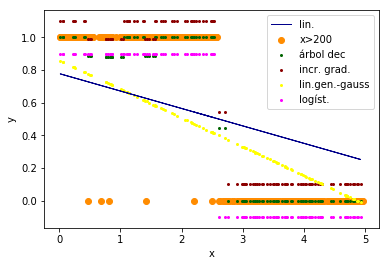

In [101]:
xtestFrame = test_df.select(['features']).collect()
xtest = list(map(lambda x: x.features[0],xtestFrame))
y_lrFrame = lr_predictions.select(['prediction']).collect()
y_lr = list(map(lambda y: y.prediction,y_lrFrame))
y_dtFrame = dt_predictions.select(['prediction']).collect()
y_dt = list(map(lambda y: y.prediction,y_dtFrame))
y_gbFrame = gbt_predictions.select(['prediction']).collect()
y_gb = list(map(lambda y: y.prediction+0.1,y_gbFrame))
y_glrFrame = glr_predictions.select(['prediction']).collect()
y_glr = list(map(lambda y: y.prediction-0.1,y_glrFrame))
if etiq.startswith("x>"):
    y_logistrFrame = logistr_predictions.select(['prediction']).collect()
    y_logistr = list(map(lambda y: y.prediction-0.1,y_logistrFrame))

plt.scatter(X, y, color='darkorange', label=etiq)
lw=1
s=4
plt.plot(xtest, y_lr, color='darkblue', lw=lw,label='lin.')
plt.scatter(xtest, y_dt, color='darkgreen',s=s,label='árbol dec')
plt.scatter(xtest, y_gb, color='darkred', s=s,label='incr. grad.')
plt.scatter(xtest, y_glr, color='yellow', s=s,label='lin.gen.-gauss')
if etiq.startswith("x>"):
    plt.scatter(xtest, y_logistr, color='magenta', s=s,label='logíst.')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
